### import


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from pprint import pprint
from PIL import Image

from google_play_scraper import reviews, Sort

from konlpy.tag import Okt
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from stopwords import get_stopwords  # 만약 오류 나면 직접 stopwords 리스트 사용

import warnings

warnings.filterwarnings("ignore")

### 데이터 수집


### 구글 playstore 리뷰 데이터


In [3]:
def gstore_reviews(app_id):
    # 리뷰 가져오기
    result = reviews(
        app_id,
        lang="ko",  # 한국어 리뷰
        country="kr",  # 한국
        sort=Sort.NEWEST,  # 최신 리뷰 먼저 가져오기
        count=100000,  # 가져올 리뷰 수 (최대 100000)
    )

    # 리뷰 데이터
    review_data = result[0]

    # DataFrame으로 변환
    return pd.DataFrame(review_data)

In [4]:
qz_df = gstore_reviews("com.quizlet.quizletandroid")
# qz_df.to_csv("/data/quizlet_rv.csv", index=False, encoding="utf-16")

In [5]:
qz_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4824 entries, 0 to 4823
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   reviewId              4824 non-null   object        
 1   userName              4824 non-null   object        
 2   userImage             4824 non-null   object        
 3   content               4824 non-null   object        
 4   score                 4824 non-null   int64         
 5   thumbsUpCount         4824 non-null   int64         
 6   reviewCreatedVersion  4466 non-null   object        
 7   at                    4824 non-null   datetime64[ns]
 8   replyContent          174 non-null    object        
 9   repliedAt             174 non-null    datetime64[ns]
 10  appVersion            4466 non-null   object        
dtypes: datetime64[ns](2), int64(2), object(7)
memory usage: 414.7+ KB


### 사용자 리뷰를 토대로 Quizlet의 학습용, 교구용 비율 분석


In [6]:
# 학습용 분류 키워드 설정
study_keywords = [
    "시험",
    "문제",
    "단어",
    "개념",
    "복습",
    "암기",
    "테스트",
    "학습",
    "공부",
    "연습",
]
# 교구용 분류 키워드 설정
teaching_keywords = [
    "수업",
    "퀴즈",
    "교사용",
    "학습지",
    "학생",
    "수업자료",
    "활동",
    "플래시카드",
]


# 함수 정의
def categorize_content(text):
    if isinstance(text, str):  # 문자열인지 확인
        if any(word in text for word in study_keywords):
            return "학습용"
        elif any(word in text for word in teaching_keywords):
            return "교구용"
    return "기타"


# category 컬럼 추가, values = "학습용", "교구용", "기타"
qz_df["category"] = qz_df["content"].apply(categorize_content)

# 카테고리별 비율 계산
category_counts = qz_df["category"].value_counts(normalize=True) * 100
category_counts

category
기타     61.028192
학습용    38.204809
교구용     0.766998
Name: proportion, dtype: float64

In [7]:
# 기타 사용자 리뷰 분석
def etc_content(text):
    if isinstance(text, str):  # 문자열인지 확인
        if any(word in text for word in study_keywords):
            return False
        elif any(word in text for word in teaching_keywords):
            return False
    return True


filtered_etc_df = qz_df[qz_df["content"].apply(etc_content)][
    ["userName", "content", "score"]
].reset_index(drop=True)
filtered_etc_df

,userName,content,score
0,안혜원,좋아요,5
1,manman k,"연간회원 업그레이드하려고하는데, ""업그레이드실패"" 라고 뜨면서 안돼요",2
2,Dong Kyoo Lee,Best!,5
3,공희정,좋다,4
4,주성환,훌륭,5
...,...,...,...
2939,Google 사용자,It's so nice that i can use it both in laptops...,5
2940,Google 사용자,Great!!!!,5
2941,Google 사용자,Great!,5
2942,Google 사용자,Sublime.,5


In [8]:
# 학습용 분류 키워드 설정
study_keywords = [
    "시험",
    "문제",
    "단어",
    "개념",
    "복습",
    "암기",
    "테스트",
    "학습",
    "공부",
    "연습",
    "외우기",
    "기출",
    "성적",
    "점수",
    "이해",
    "과제",
    "문제풀이",
    "암기법",
    "테스트 준비",
]
# 교구용 분류 키워드 설정
teaching_keywords = [
    "수업",
    "퀴즈",
    "교사용",
    "학습지",
    "학생",
    "수업자료",
    "활동",
    "플래시카드",
    "교육",
    "강의",
    "수업 계획",
    "학생 참여",
    "교재",
    "활동지",
    "학습지도",
    "과제 관리",
    "교사용 자료",
]

# category 컬럼 추가, values = "학습용", "교구용", "기타"
qz_df["category"] = qz_df["content"].apply(categorize_content)

# 카테고리별 비율 계산
category_counts = qz_df["category"].value_counts(normalize=True) * 100
category_counts

category
기타     60.364842
학습용    38.785240
교구용     0.849917
Name: proportion, dtype: float64

### 유료 요금제 관련 리뷰 분석


In [9]:
# 유료 요금 관련 리뷰 키워드 설정
plus_keywords = [
    "유료",
    "플러스",
    "돈",
    "plus",
]


def paid_user_content(text):
    if isinstance(text, str):  # 문자열인지 확인
        if any(word in text for word in plus_keywords):
            return text  # 키워드 포함된 경우, 원래 텍스트 반환
    return None  # 키워드 미포함 시 None 반환


# 필터링된 리뷰만 저장
result_df = (
    qz_df["content"]
    .apply(paid_user_content)
    .dropna()
    .reset_index(drop=True)
    .to_frame(name="content")
)

# result_df.to_csv("/data/plus_rv.csv", index=False, encoding="utf-16", header=False)
result_df

,content
0,기능은 좋은 데 주변에 같이 하고있는 친구들은 유료 결제를 안해도 테스트가 여러번 ...
1,유료인게 쫌 아쉽지만 학습에는 퀴즈렛 만한기 없다
2,유료ㅜ
3,퀴즐렛 플러스를 결제했는데 낱말카드에 이미지를 저장하려고 하면 계속 로그아웃이 되고...
4,유료결제 취소를 원해요
...,...
226,무료지만 유료같은 어플
227,와..ㅋㅋ 너무 좋네요. 유료여도 돈내고 다운받고싶을 정도로 훌륭한 앱입니다👍 디자...
228,구성도 좋고 테스트도 다양해서 좋네요. 유료로 업그레이드 할 의향도 든다는 ㅎㅎ
229,영어 뿐만이 아니라 제가 등록한 모든 단어의 발음지원이 된다는 사실에 놀랐네요. 깔...


In [10]:
scan_keywords = [
    "스캔",
    "스캐닝",
    "인식",
    "OCR",
    "ocr",
]


def neg_content(text):
    if isinstance(text, str):  # 문자열인지 확인
        if any(word in text for word in scan_keywords):
            return "스캔"
    return "기타"


result_df["category"] = result_df["content"].apply(neg_content)

# 카테고리별 비율 계산
scan_ctg_cnt = result_df["category"].value_counts(normalize=True) * 100
scan_ctg_cnt

category
기타    93.939394
스캔     6.060606
Name: proportion, dtype: float64

In [20]:
# 스캔 리뷰 분석
def scan_content(text):
    if isinstance(text, str):  # 문자열인지 확인
        if any(word in text for word in scan_keywords):
            return True
    return False


filtered_scan_df = qz_df[qz_df["content"].apply(scan_content)][
    ["userName", "content", "score", "at"]
].reset_index(drop=True)
filtered_scan_df

,userName,content,score,at
0,O,유료기능 솔직히 값어치 못함 그리고 자잘한 버그가 너무 많음 스캔오류가 너무 많이뜸...,2,2024-09-30 11:34:06
1,황인태,"폴더안에 단어장 사라지는 버그는 고쳐진거 같아서 좋습니다. 근데, 폴더 안에서 단어...",3,2024-08-24 18:18:01
2,ᄋᄉᄋ,돈내고 쓰는건데 제발 문서 스캔 인식 좀...,2,2024-06-15 19:14:17
3,엘리,터치가 잘 안 됩니다. 단어 카드를 뒤집을 때 뒤집기가 아니라 카드 넘기는 모션으로...,1,2023-06-20 10:08:38
4,전형우,업데이트 하니까 화면전환이 느려터져짐. 제일 중요한건 단어 뜻을 작성하려고 클릭해도...,2,2023-02-28 23:55:48
5,이크에크,문서스캔 기능 구림. 차라리 웹사이트에 사진 넣고 돌리는게 더 나을 듯. 돈 아까운...,1,2023-01-02 22:20:21
6,안수린,단어를 외우고 학습하기 좋은 앱이에요 💯 단어를 적을때 사진을 찍어 인식하는 그런 ...,4,2022-10-18 16:48:19
7,김다온,이럴거면 그냥 유료어플로 하지 왜 무료다운받을 수 있고 이용하는데는 유료인가요......,1,2022-09-25 22:22:01
8,안효은,완벽했던 앱이 왜 이렇게 쇠퇴했는지 모르겠습니다. 단어를 외울 때도 수행평가를 준비...,1,2022-08-19 22:37:01
9,Chloe KIM,플러스 가입을 했는데 학습세트만들기에서 문서스캔하기가 안보입니다,5,2022-03-09 23:17:14


### 워드클라우드 생성


In [11]:
def get_WordCloud(df, title):
    okt = Okt()

    # 한국어 불용어
    korean_stopwords = set(get_stopwords(language="korean"))
    custom_stopwords = {
        "이",
        "그",
        "저",
        "것",
        "나",
        "너",
        "우리",
        "저희",
        "그들",
        "그녀",
        "입니다",
        "하",
        "이것",
        "저것",
        "다",
        "되다",
        "하다",
        "있다",
        "없다",
        "과",
        "도",
        "의",
        "는",
        "은",
        "를",
        "이",
        "가",
        "에서",
        "에",
        "을",
        "아주",
        "진짜",
        "정말",
        "가장",
        "너무",
        "정말로",
        "대해",
        "대하여",
        "이건",
        "모든",
        "저건",
        "통해",
        "제발",
        "자꾸",
        "계속",
        "이후",
        "부분",
        "완전",
        "그냥",
        "걍",
        "이면",
        "때문",
        "내지",
        "해도",
        "달이",
    }
    total_stopwords = korean_stopwords.union(custom_stopwords)

    combined_text = " ".join(df["content"].astype(str))

    tokens_ko = okt.nouns(combined_text)

    filtered_tokens = [
        word for word in tokens_ko if word not in total_stopwords and len(word) > 1
    ]

    word_freq = Counter(filtered_tokens)

    top_words = word_freq.most_common(80)
    #     print("상위 50개 단어:", top_100_words)  # 상위 50개 단어 출력
    # bubble_mask = np.array(Image.open('./img/YoonseokChoi.jpg'))
    wordcloud = WordCloud(
        font_path="C://Windows/Fonts/malgun.ttf",  # Windows 한글 폰트 경로
        width=300,
        height=150,
        background_color="black",  # 배경색
        colormap="Pastel1",  # 색상 맵 (색상 팔레트)
        #         max_font_size=200,  # 최대 폰트 크기
        #         min_font_size=10,  # 최소 폰트 크기
        max_words=80,  # 최대 단어 수
        #         contour_color='black',  # 단어 클라우드 외곽선 색상
        #         contour_width=1,  # 외곽선 두께
        #         random_state=42,  # 결과 일관성 유지
        # mask = bubble_mask
    ).generate_from_frequencies(dict(top_words))

    # 워드 클라우드 출력
    plt.figure(figsize=(10, 10))
    plt.title(title, fontsize=18, fontweight="bold", loc="left")
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

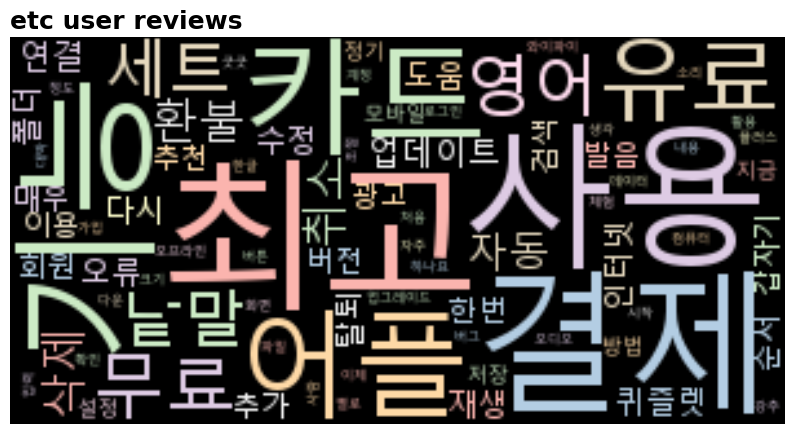

In [13]:
# 기타 사용자 리뷰 분석 워드클라우드
get_WordCloud(filtered_etc_df, "etc user reviews")

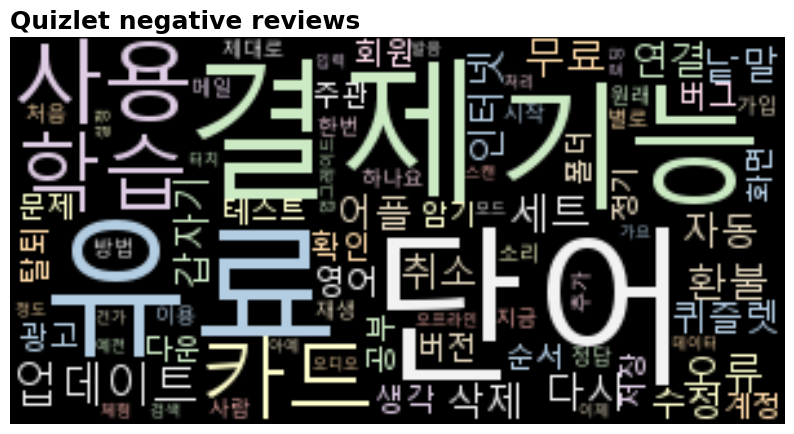

In [14]:
# 부정 리뷰 분석 워드클라우드
get_WordCloud(qz_df[qz_df["score"] <= 2], "Quizlet negative reviews")

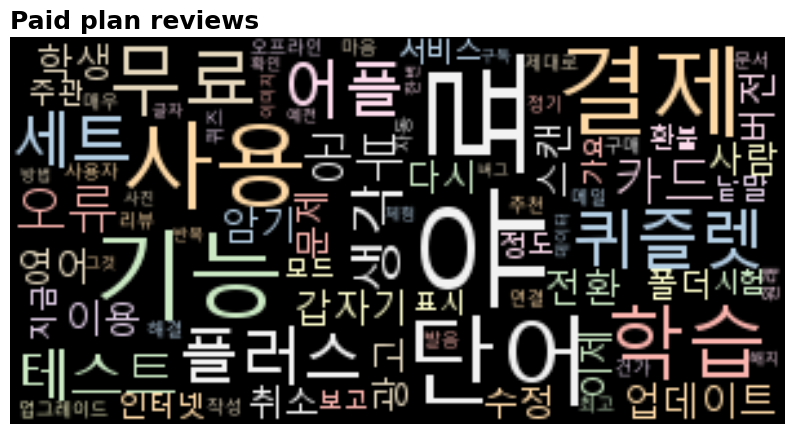

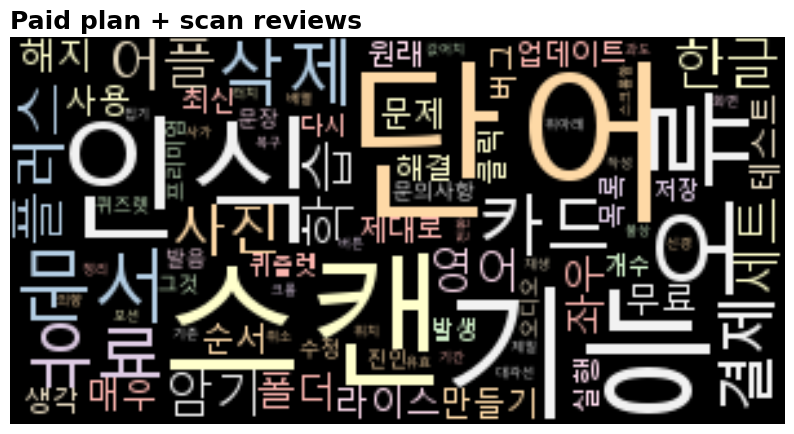

In [21]:
# 프리미엄 관련 리뷰
get_WordCloud(result_df, "Paid plan reviews")
get_WordCloud(filtered_scan_df, "Paid plan + scan reviews")